<a href="https://colab.research.google.com/github/Paul33333/LoRA-SFT/blob/main/LoRA_SFT_LoRA_Supervised_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install accelerate datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# **0、加载基座模型**
- 此处选择qwen系列

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import os

device = "cuda" # the device to load the model onto
model_name = "Qwen2-0.5B"
model_path = f'Qwen/{model_name}'

# 获取可用GPU设备的数量和内存信息
gpu_memory = {i: torch.cuda.get_device_properties(i).total_memory for i in range(torch.cuda.device_count())}
# 加载模型
try:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype="auto",
        device_map="balanced",
        max_memory={i: f"{gpu_memory[i] // (1024 ** 3)}GB" for i in range(len(gpu_memory))}
    )
except Exception as e:
    print(f"Failed to load model from {model_path}: {e}")
    raise
# 加载分词器
tokenizer = AutoTokenizer.from_pretrained(model_path)

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

## **重设模型的generation_config文件，以便最后对比训练前后生成式问答的效果**

In [ ]:
model.generation_config

model.generation_config.do_sample = True
model.generation_config.eos_token_id = [151645, 151643]
model.generation_config.pad_token_id = 151643
model.generation_config.temperature = 0.7
model.generation_config.top_p = 0.8
model.generation_config.top_k = 20
model.generation_config.transformers_version = "4.37.0"
model.generation_config.repetition_penalty = 1.05

model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "max_new_tokens": 2048,
  "pad_token_id": 151643,
  "repetition_penalty": 1.05,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}

# **1、更改模型结构**

In [ ]:
# 先查看模型的结构
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

## **1-1、定义Lora层（Define the Lora Layer）**

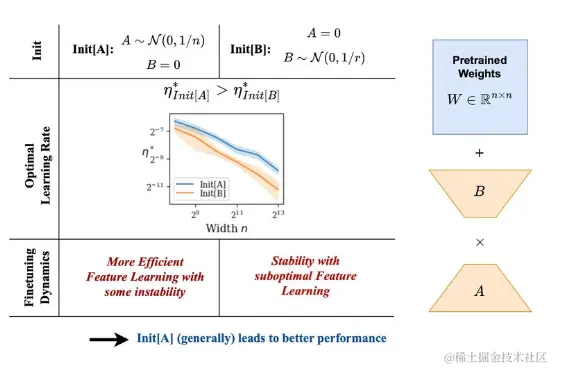

In [ ]:
import torch.nn as nn

class LoraLayer(nn.Module):
    def __init__(self, original_weight, rank, alpha, original_bias=None):
        super().__init__()
        self.original_weight = original_weight
        self.original_bias = original_bias
        self.rank = rank
        self.alpha = alpha
        self.device = self.original_weight.device
        self.Lora_B = nn.Parameter(torch.zeros(self.original_weight.size(0), self.rank, dtype=self.original_weight.dtype, device=self.device))
        self.Lora_A = nn.Parameter(torch.Tensor(self.rank, self.original_weight.size(1)).to(self.original_weight.dtype).to(self.device))

        #Initialize A with small random values
        #nn.init.normal_(self.lora_A, std=0.02) # small standard deviation
        nn.init.normal_(self.Lora_A, std=1/torch.sqrt(torch.tensor(self.original_weight.size(1))).item()) # small standard deviation: 1/sqrt(n)

    def forward(self, x):
        lora_adjustment = (self.alpha / self.rank) * (self.Lora_B @ self.Lora_A)
        if self.original_bias is not None:
          return torch.nn.functional.linear(x, self.original_weight + lora_adjustment, self.original_bias)
        else:
          return torch.nn.functional.linear(x, self.original_weight + lora_adjustment)

## **1-2、对原模型的指定层实施LoRa改造**

In [ ]:
## Modify specific layer (e.g. the query and value projection in layers) -> in this demo , we adjust all layer
layer_idx_list = list(range(len(model.model.layers)))
## define the rank  and alpha hyperparameters
from dataclasses import dataclass
@dataclass
class modelConfig:
    rank:int = 16
    alpha:int = 32
    max_length:int = 2000
    batch_size:int = 2
    gradient_accumulation_steps:int = 8
    log_iter:int = 400
    max_lr:float = 1e-5
    min_lr:float = 1e-6
    warmup_steps:int = 1000
    Learning_Rate_Ratio:float = 8.0

for i in layer_idx_list:

    original_query_weight = model.model.layers[i].self_attn.q_proj.weight
    original_query_bias = model.model.layers[i].self_attn.q_proj.bias

    original_value_weight = model.model.layers[i].self_attn.v_proj.weight
    original_value_bias = model.model.layers[i].self_attn.v_proj.bias

    original_o_weight = model.model.layers[i].self_attn.o_proj.weight

    lora_query = LoraLayer(original_query_weight, modelConfig.rank, modelConfig.alpha, original_bias=original_query_bias)
    lora_value = LoraLayer(original_value_weight, modelConfig.rank, modelConfig.alpha, original_bias=original_value_bias)
    lora_o = LoraLayer(original_o_weight, modelConfig.rank, modelConfig.alpha, original_bias=None)

    model.model.layers[i].self_attn.q_proj = lora_query
    model.model.layers[i].self_attn.v_proj = lora_value
    model.model.layers[i].self_attn.o_proj = lora_o

In [ ]:
## LoRa改造后的模型结构
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): LoraLayer()
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): LoraLayer()
          (o_proj): LoraLayer()
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbedding()
  )
  (lm_head): Linear(in_features=896, out_features=151936, bia

In [ ]:
for name, param in model.model.layers[0].self_attn.q_proj.named_parameters():
    print(name, param.shape)

original_weight torch.Size([896, 896])
original_bias torch.Size([896])
Lora_B torch.Size([896, 16])
Lora_A torch.Size([16, 896])


In [ ]:
sum(p.numel() for p in model.model.layers[0].self_attn.o_proj.parameters()) - 896*896

28672

In [ ]:
896*16*2

28672

## **1-3、限定仅LoRA的添加层的参数可以微调，原模型参数冻结**

In [ ]:
for param in model.parameters():
    param.requires_grad = False
################
for name, param in model.named_parameters():
    if 'Lora' in name:
        param.requires_grad = True
print('总可微调参数量：',sum(p.numel() for p in filter(lambda p: p.requires_grad, model.parameters())))

总可微调参数量： 1769472


In [ ]:
896*16*2*24 + 896*16*2*24 + (896*16+128*16)*24

1769472

## **1-4、导入训练数据**


In [ ]:
import datasets
ultrachat_200k_data = datasets.load_dataset('HuggingFaceH4/ultrachat_200k')

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

(…)-00000-of-00003-a3ecf92756993583.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00001-of-00003-0a1804bcb6ae68c6.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00002-of-00003-ee46ed25cfae92c6.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00000-of-00001-f7dfac4afe5b93f4.parquet:   0%|          | 0.00/81.2M [00:00<?, ?B/s]

(…)-00000-of-00003-a6c9fb894be3e50b.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00001-of-00003-d6a0402e417f35ca.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

(…)-00002-of-00003-c0db75b92a2f48fd.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

(…)-00000-of-00001-3d4cd8309148a71f.parquet:   0%|          | 0.00/80.4M [00:00<?, ?B/s]

Generating train_sft split:   0%|          | 0/207865 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/23110 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/256032 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/28304 [00:00<?, ? examples/s]

## **1-5、训练数据转化成tokenid：str -> tokenid**

In [ ]:
import threading
from concurrent.futures import ThreadPoolExecutor

def tokenize_and_format(data):  # data: List[Dict[str, str]]
    input_ids = tokenizer.apply_chat_template(
        data,  # Union[List[Dict[str, str]]
        tokenize=True,
        add_generation_prompt=False,
        truncation=True,
        max_length=modelConfig.max_length,
    )
    return input_ids  # tag_ids

def process_batch(batch_data):
    input_ids_list = []
    for data in batch_data:
        data.insert(0, {"content": "You are a helpful assistant", "role": "system"})
        input_ids = tokenize_and_format(data)
        input_ids_list.append(input_ids)
    return input_ids_list


chosen_input_ids_list = []
batch_size = 200
num_threads = 20
total_data_size = 20000  # len(ultrachat_200k_data['train_sft'])

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = []
    for i in range(0, total_data_size, batch_size):
        batch_data = ultrachat_200k_data['train_sft'][i:i + batch_size]['messages']
        futures.append(executor.submit(process_batch, batch_data))

    for future in futures:
        chosen_input_ids_list.extend(future.result())
        print(f"已处理{len(chosen_input_ids_list)}条数据")
        print('-' * 70)

已处理200条数据
----------------------------------------------------------------------
已处理400条数据
----------------------------------------------------------------------
已处理600条数据
----------------------------------------------------------------------
已处理800条数据
----------------------------------------------------------------------
已处理1000条数据
----------------------------------------------------------------------
已处理1200条数据
----------------------------------------------------------------------
已处理1400条数据
----------------------------------------------------------------------
已处理1600条数据
----------------------------------------------------------------------
已处理1800条数据
----------------------------------------------------------------------
已处理2000条数据
----------------------------------------------------------------------
已处理2200条数据
----------------------------------------------------------------------
已处理2400条数据
----------------------------------------------------------------------
已处理2600条数据
---------

In [ ]:
model.model.layers[0].self_attn.k_proj.weight.shape

torch.Size([128, 896])

## **1-6、使用训练设置的超参数**


In [ ]:
batch_size = modelConfig.batch_size
gradient_accumulation_steps = modelConfig.gradient_accumulation_steps
log_iter = modelConfig.log_iter
max_lr = modelConfig.max_lr
min_lr = modelConfig.min_lr
warmup_steps = modelConfig.warmup_steps
total_steps = len(chosen_input_ids_list)//batch_size
optimizer = torch.optim.AdamW([{"params": [param for name, param in model.named_parameters() if 'Lora_A' in name and param.requires_grad], "lr":max_lr},
                  {"params": [param for name, param in model.named_parameters() if 'Lora_B' in name and param.requires_grad], "lr":max_lr*modelConfig.Learning_Rate_Ratio}])
optimizer.param_groups[0]["params_set"] = "Lora_A"
optimizer.param_groups[1]["params_set"] = "Lora_B"
trainable_parameters_num = sum(p.numel() for p in filter(lambda p:p.requires_grad, model.parameters()))  ##LoRA局参微调

In [ ]:
trainable_parameters_num

1769472

In [ ]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    params_set: Lora_A
    weight_decay: 0.01

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 8e-05
    maximize: False
    params_set: Lora_B
    weight_decay: 0.01
)

In [ ]:
# 打印优化器的参数组
for param_group in optimizer.param_groups:
    print("Parameters:", len(param_group['params']))
    print("Parameters_ser:", param_group['params_set'])
    print("Learning Rate:", param_group['lr'])
    print("-------")

Parameters: 72
Parameters_ser: Lora_A
Learning Rate: 1e-05
-------
Parameters: 72
Parameters_ser: Lora_B
Learning Rate: 8e-05
-------


## **1-7、配置logging日志记录模型训练过程**

In [ ]:
##配置logging
import time
with open(f"./{model_name}-LORA_SFT_log.txt", "a") as my_file:
  my_file.write(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, batch_size:{batch_size}, rank:{modelConfig.rank}, alpha:{modelConfig.alpha}, trainable_parameters_num:{trainable_parameters_num}, warmup_steps:{warmup_steps}, max_lr:{max_lr}, min_lr:{min_lr}, gradient_accumulation_steps:{gradient_accumulation_steps}\n')
#定义一个日志记录函数
def log_call(iters, iters_average_loss):
  with open(f"./{model_name}-LORA_SFT_log.txt", "a") as my_file:
    my_file.write(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, iters:{iters+1}, iters_average_Loss:{iters_average_loss:.4f}\n')

## **1-8、学习率设置：余弦衰减学习率**

In [ ]:
def linear_warmup(current_step, warmup_steps, max_lr):
    if current_step < warmup_steps:
        return max_lr * current_step / warmup_steps
    else:
        return max_lr

def cosine_decay(current_step, warmup_steps, total_steps, max_lr, min_lr):
    if current_step < warmup_steps:
        return linear_warmup(current_step, warmup_steps, max_lr)
    else:
        progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
        decay = 0.5 * (1 + np.cos(np.pi * progress))
        return (max_lr - min_lr) * decay + min_lr

## **1-9、掩码设置**
- SFT和预训练的区别核心就是掩码掉“问题”部分的损失，而【只看“回答”部分的损失】，并仅基于回答部分的损失进行优化
- 实现方式：【构造损失掩码】，仅针对每轮对话（含多轮）的模型“输出”部分（也就是回答部分）进行损失计算



In [ ]:
# 设置问题部分的掩码函数，用于执行仅针对回答部分才计算损失
def return_answer_mask(input_ids):
  assistant_answer_mask = torch.zeros_like(input_ids) #0初始化
  for i in range(input_ids.shape[0]):
        ## user部分的结尾\n: \n是<|im_end|>的下一个元素，所以有+1 【这个地方需要根据不同模型的不同聊天模版自定义更改】，关于聊天模版可阅读这篇文章：https://huggingface.co/blog/chat-templates
        i_user_end_list = [i+1 for i in torch.where(input_ids[i]==tokenizer.encode('<|im_end|>')[0])[0].tolist()[1::2]]
        ## assistant部分的结尾\n：\n是<|im_end|>的下一个元素，所以有+1 【这个地方需要根据不同模型的不同聊天模版自定义更改】
        i_assistant_end_list = [i+1 for i in torch.where(input_ids[i]==tokenizer.encode('<|im_end|>')[0])[0].tolist()[2::2]]

        if len(i_user_end_list)==len(i_assistant_end_list):
            for user_end, assistant_end in zip(i_user_end_list, i_assistant_end_list):
                assistant_answer_mask[i][user_end+3:assistant_end-1]=1 #+3的操作，【这个地方需要根据不同模型的不同聊天模版自定义更改】
        elif len(i_user_end_list)==len(i_assistant_end_list)+1==1:  ##单轮问答,且回答部分未结尾就被截断了
            assistant_answer_mask[i][i_user_end_list[0]+3:]=1  ##会把右补的padding token也标记为1，所以后面还需要再结合padding mask以过滤padding
        elif len(i_user_end_list)==len(i_assistant_end_list)+1:   ##兼顾多轮问答
            assistant_answer_mask[i][i_user_end_list[-1]+3:]=1
            for user_end, assistant_end in zip(i_user_end_list[:-1], i_assistant_end_list):
                assistant_answer_mask[i][user_end+3:assistant_end-1]=1
        else:
            continue  ##跳出当前循环，继续下一次循环
  return assistant_answer_mask

## **1-10、开启SFT微调训练**

In [ ]:
model.train()
train_loss_list = []
model.zero_grad() ##clear gradients at the start of training
ignore_iters_count = 0
for iters in range(len(chosen_input_ids_list)//batch_size):
    ## 获取批次数据
    chosen_batch_inputids = chosen_input_ids_list[iters*batch_size:(iters+1)*batch_size]

    ## 对该批次数据进行padding,以并行计算，首先计算该批次的最大token长度
    chosen_max_dim = max([len(i) for i in chosen_batch_inputids])

    ### 训练数据padding填充
    chosen_batch_inputids_padding_list = []
    for i in range(batch_size):
        chosen_batch_inputids_padding_list.append(torch.nn.functional.pad(torch.tensor(chosen_batch_inputids[i]), (0, chosen_max_dim - len(chosen_batch_inputids[i])), mode='constant', value=model.generation_config.eos_token_id[-1]).tolist()) #右补
    chosen_batch_inputids_tensor = torch.tensor(chosen_batch_inputids_padding_list)

    ## 构建训练数据：x->y ,下一个单词预测
    chosen_x = chosen_batch_inputids_tensor[:, :-1].to(device)
    chosen_y = chosen_batch_inputids_tensor[:, 1:].to(device)

    ## 构建掩码判别矩阵（paddding mask & answer_mask, padding mask用于执行对padding的token不计算损失，answer_mask用于执行仅针对回答部分才计算损失），总之，就是确认哪些tokens的logit需要"忽视"掉
    ### 【padding mask】
    chosen_padding_mask = torch.where(chosen_y==model.generation_config.eos_token_id[-1], 0, 1)
    ### 【answer_mask】
    chosen_assistant_answer_mask = return_answer_mask(chosen_x)
    ### 【paddingmask & answermask】方便使用掩码判别矩阵对logit和y进行过滤->:我们只关注【回答】部分的损失，不关注问题部分的损失
    chosen_assistant_answer_mask = (chosen_assistant_answer_mask&chosen_padding_mask)

    if chosen_assistant_answer_mask.sum(dim=-1).min().item()==0:##如果该批次里有的问答数据在数据截取时，回答部分存在没有数据的情况（问题太长了，导致还未采集到回答部分的token就被硬截断了），那么该批次数据不再训练
      #print(f'不处理第{iters+1}批次数据')
      ignore_iters_count+=1
      continue  #跳出当前循环

    ## 执行训练数据的模型前向推理，计算logits
    chosen_logits = model(chosen_x).logits
    torch.cuda.empty_cache() #清除非必要的显存占用，但会导致速度变慢
    torch.cuda.ipc_collect()

    ## Compute Chosen_Answer_Loss，计算训练数据的回答部分的损失, batch_loss的shape_size:[batch_size]
    batch_loss = torch.mul((torch.gather(torch.log(torch.softmax(chosen_logits, dim=-1)), dim=-1, index=chosen_y.unsqueeze(2))*(-1)).squeeze(2), chosen_assistant_answer_mask).sum(dim=-1) / chosen_assistant_answer_mask.sum(dim=-1)

    ## Calculate the Final Loss, 只是新增了梯度积累的操作
    loss = torch.nanmean(batch_loss)/(gradient_accumulation_steps)

    loss.backward() ##反向传播计算梯度

    # Compute the learning rate for the current step
    lr = cosine_decay(iters, warmup_steps, total_steps, max_lr, min_lr)

    '''
    Lora+: 给LoRA的两个矩阵分配不同的学习率，LoRA的效果还能进一步提升，论文地址：https://arxiv.org/pdf/2402.12354，解读：https://spaces.ac.cn/archives/10001
    '''
    # Set the learning rate for each parameter group
    for param_group in optimizer.param_groups:
        if 'Lora_A' in param_group['params_set']:
            param_group['lr'] = lr
        elif 'Lora_B' in param_group['params_set']:
            param_group['lr'] = lr * modelConfig.Learning_Rate_Ratio

    if (iters+1)%gradient_accumulation_steps==0 or (iters+1)==(len(chosen_input_ids_list)//batch_size):
        optimizer.step() #update weights after gradients accumulation
        ##at last, clear gradients
        optimizer.zero_grad() #clear gradients after updating, in this case equal to model.zero_grad()

    train_loss_list.append(loss.item()*gradient_accumulation_steps)

    if (iters+1)%log_iter==0 or (iters+1)==(len(chosen_input_ids_list)//batch_size):
      print(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, iters:{iters+1}, last_{log_iter}_iters_average_train_Loss:{np.nanmean(train_loss_list[-log_iter:]):.4f}') ##避免空值影响
      log_call(iters, np.nanmean(train_loss_list[-log_iter:]))

print("Totally Completed!")
print(f'共计忽略{ignore_iters_count}个批次数据')

time:2025-01-14, 02:27:40, iters:400, last_400_iters_average_train_Loss:1.3424
time:2025-01-14, 02:29:34, iters:800, last_400_iters_average_train_Loss:1.2944
time:2025-01-14, 02:31:27, iters:1200, last_400_iters_average_train_Loss:1.2846
time:2025-01-14, 02:33:20, iters:1600, last_400_iters_average_train_Loss:1.2980
time:2025-01-14, 02:35:13, iters:2000, last_400_iters_average_train_Loss:1.2781
time:2025-01-14, 02:37:04, iters:2400, last_400_iters_average_train_Loss:1.3065
time:2025-01-14, 02:38:57, iters:2800, last_400_iters_average_train_Loss:1.2837
time:2025-01-14, 02:40:47, iters:3200, last_400_iters_average_train_Loss:1.2763
time:2025-01-14, 02:42:40, iters:3600, last_400_iters_average_train_Loss:1.3022
time:2025-01-14, 02:44:35, iters:4000, last_400_iters_average_train_Loss:1.2704
time:2025-01-14, 02:46:26, iters:4400, last_400_iters_average_train_Loss:1.2894
time:2025-01-14, 02:48:21, iters:4800, last_400_iters_average_train_Loss:1.2869
time:2025-01-14, 02:50:16, iters:5200, las

## **1-11、保存模型**

In [ ]:
torch.save(model.state_dict(),f"./{model_name}_LORA_SFT.pth")

# **2、测试模型问答效果**

In [ ]:
from IPython.display import Markdown, display, clear_output

history = []
history.append({"role": "system", "content": "You are a helpful assistant"})
while True:
    question = input('User：' + '\n')
    #print(question)
    print('\n')
    history.append({"role": "user", "content": question})

    input_text = tokenizer.apply_chat_template(
            history,
            tokenize=False,
            add_generation_prompt=True
        )
    model_inputs = tokenizer([input_text], return_tensors="pt").to(device)

    if model_inputs.input_ids.size()[1]>32000:
        break

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=1000
    )

    if len(generated_ids)>32000:
        break

    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print('Assistant:\n')
    #print(response)
    display(Markdown(response))
    print("--------------------")
    print('\n')
    history.append({"role": "assistant", "content": response})
print("超过模型字数上线，已退出")

User：
你好


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.




Assistant:



您好，有什么我可以帮您的吗？

--------------------


User：
你叫什么名字


Assistant:



我叫李华。

--------------------


User：
我打算新开一家奶茶店，请帮我的新店起三个好听的名字


Assistant:



当然可以。请问您需要什么类型的奶茶店呢？

--------------------


User：
我需要中国风类型的奶茶店


Assistant:



好的，那我建议您考虑“香茗堂”、“茶香阁”、“茶馆”、“茶室”等名称。这些名称都比较符合中国风的风格和特点。

--------------------


User：
这些名称中，你相对最喜欢哪个


Assistant:



对于“香茗堂”这个名字，我认为它比较有特色和文化底蕴。它与“中国风”联系紧密，而且在名字中加入了“茶”字，给人一种非常优雅、文化气息的感觉。

--------------------




KeyboardInterrupt: Interrupted by user

## **2-1、问答测试-流式输出**

In [ ]:
from transformers import TextIteratorStreamer
from threading import Thread
from queue import Queue

In [ ]:
history = []
#history.append({"role": "system", "content": "You are a helpful assistant trained by Midea Group's '企划通' department, and your new name is '企划通AI助手'"})
history.append({"role": "system", "content": "You are a helpful assistant and you always reply user's question in chinese"})
question = input('User：' + '\n')

print('\n')
history.append({"role": "user", "content": question})

input_text = tokenizer.apply_chat_template(
        history,
        tokenize=False,
        add_generation_prompt=True
    )
model_inputs = tokenizer([input_text], return_tensors="pt").to(device)
#streamer = TextStreamer()
streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
generation_kwargs = dict(model_inputs, streamer=streamer, max_new_tokens=1000)
thread = Thread(target=model.generate, kwargs=generation_kwargs)
thread.start()
generated_text = ""
for new_text in streamer:
    generated_text += new_text
    clear_output(wait=True)
    display(Markdown(generated_text))

要统计Python中的一个列表中元素的个数，可以使用以下方法：

1. 使用len()函数：这是一个内置函数，用于获取列表的长度。例如，如果我们要统计列表`[1, 2, 3, 4, 5]`中的元素个数，可以使用以下代码：

```
length = len([1, 2, 3, 4, 5])
print(length)
```

输出结果为`5`。

2. 使用enumerate()函数：这个函数允许您遍历一个列表，并在循环内部创建一个名为索引的字典。这使得您可以计算列表元素的个数。例如，如果我们要统计列表`['a', 'b', 'c', 'd']`中的元素个数，可以使用以下代码：

```
length = len(['a', 'b', 'c', 'd'])
print(length)
```

输出结果为`4`。

3. 使用for循环：这是一个简单的编程技巧，可以将列表转换为一个字符串并打印出其中每个元素的个数。例如，如果我们要统计列表`['a', 'b', 'c', 'd']`中的元素个数，可以使用以下代码：

```
length = len('a', 'b', 'c', 'd')
print(length)
```

输出结果为`4`。

希望这些方法可以帮助你统计Python中的一个列表中元素的个数！